In [29]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
from skimage.io import imshow, imread
from matplotlib import colors
from os import path
import ipywidgets as widgets
import sys
import math
from ipywidgets import interact, interact_manual
from sklearn.cluster import KMeans
sys.path.append(path.abspath('../MSc-CS-Project---ColourPaletteExtractor-master/'))
from colourpaletteextractor.model import model

#### 1. Select an image folder here
You will need to have a folder with images contained in the same directory as the 'notebook' folder, with the 'notebook' folder containing this .ipynb file.<br>
Example: "samuel_john_peploe" containing the images
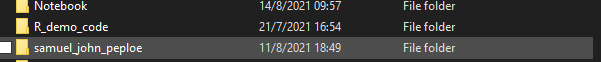

In [30]:
foldername = ''
@interact
def choose_img_folder(folder = [f for f in os.listdir('../') if '.' not in f]):
    global foldername
    foldername = folder

interactive(children=(Dropdown(description='folder', options=('LICENSE', 'MSc-CS-Project---ColourPaletteExtrac…

#### 2. Selec image file from folder here
Inside my example "samuel_john_peploe" folder, there are all the images.
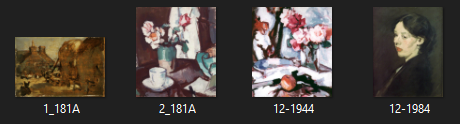

Supported formats: see __image_formats__ in code below. If nessary, edit the code to add another format.

In [32]:
image_formats = ['.jpg', '.jpeg', '.gif', '.png']
image_path = ''
image = ''
recoloured_image = 0
colour_palette = 0
relative_frequencies = 0
%matplotlib inline
@interact
def chooseimage(file = [file for file in 
                             os.listdir('../' + foldername)
                             if any(word in file for word in image_formats)]):
    global image_path, image, recoloured_image, colour_palette, relative_frequencies
    image = cv2.imread("../" + foldername + "/" + file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    imshow(image);
    image_path = "../" + foldername + "/" + file
    plt.axis('off')
    plt.show()
    recoloured_image, colour_palette, relative_frequencies = model.generate_colour_palette_from_image(image_path)

interactive(children=(Dropdown(description='file', options=('104.jpg', '12-1944.jpg', '12-1984.jpg', '1824.jpg…

### 3. Comparison of Original image and Re-Coloured image
This produces 2 images side by side for comparison. <br>
- To select different folder or image, go back to section 1 and section 2. <br><br>
- To save the recoloured image type in your directory.
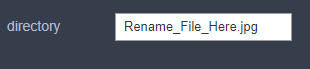
To simply save as a file, e.g. **painting_01.jpg** <br>
To save file in a folder, e.g. **folder01/painting_01.jpg** <br><br>
- Then press the button at the bottom to save file to the inserted diretory.
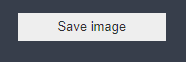

In [38]:
%matplotlib inline
@interact
def show_recoloured(directory = widgets.Text(value='Rename_File_Here.jpg', disabled=False)):
    pil_image = Image.fromarray(recoloured_image)
    cv_image = np.array(pil_image) 
    cv_image = cv_image[:, :, ::-1].copy() 
    cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, 2, figsize=(20,20), sharey = True)
    ax[0].imshow(image, cmap = 'hsv')
    ax[0].set_title("original", fontsize = 30)
    ax[0].axis('off')
    ax[1].imshow(cv_image, cmap = 'Greys')
    ax[1].set_title("recoloured", fontsize = 30)
    ax[1].axis('off')
    plt.show()
    
    def clicked(arg):
        download_img = Image.fromarray(cv_image, 'RGB')
        if len(directory.split('/')) > 1:
            split = directory.split('/')
            folders = directory.replace(split[-1], '')
            Path(folders).mkdir(parents=True, exist_ok=True)
        download_img.save(directory)
        print("saved", end='\r')
    
    save_button = widgets.Button(description = 'Save image')   
    save_button.on_click(clicked)
    display(save_button)

interactive(children=(Text(value='Rename_File_Here.jpg', description='directory'), Output()), _dom_classes=('w…

#### 4. View the Color palettes of Re-coloured image as a Pie chart with their relative frequencies


In [19]:
%matplotlib inline
def colour_palette_to_tuple_rgba(colour):
    templist = []
    for i in range(3):
        if colour[i] < 0:
            templist.append(256 + colour[i])
        else:
            templist.append(colour[i])
    return (templist[0] / 255, templist[1] / 255, templist[2] / 255)

def colour_palette_to_positive(colour):
    templist = []
    for i in range(3):
        if colour[i] < 0:
            templist.append(256 + colour[i])
        else:
            templist.append(colour[i])
    return (templist[0], templist[1], templist[2])

@interact
def show_color_palette_pie():
    my_labels = [colour_palette_to_positive(colour_palette[i]) for i in range(len(colour_palette))]
    plt.figure(figsize=(8, 8))
    plt.pie(relative_frequencies, labels = my_labels, 
            colors = [colour_palette_to_tuple_rgba(colour_palette[i]) for i in range(len(colour_palette))],
           autopct = '%1.0f%%',
        textprops={'fontsize': 8}
           )
    plt.title('Colour Palettes', fontsize=10)
    plt.axis('equal')
    plt.show()

interactive(children=(Output(),), _dom_classes=('widget-interact',))

#### 5. View RGB colour space of the orginal image
The Red, Green, Blue values of each pixel pressented in a 3D scatterplot. <br>
- To select different folder or image, go back to section 1 and section 2. <br><br>
- To adjust the scale of the image:
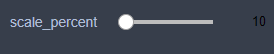
The closer it is to 100%, the longer it takes to load and the laggy it becomes when viewing it.<br><br>
- To adjust size of each dot:
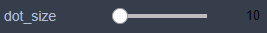

In [22]:
%matplotlib notebook 
@interact (scale_percent = (10, 100, 10), dot_size = (10, 100, 10))
def show_3dRGB(scale_percent = 10, dot_size = 10):
    global image
    temp_image = cv2.resize(image, None, fx=scale_percent/100, fy=scale_percent/100, interpolation = cv2.INTER_AREA) 
    
    r, g, b = cv2.split(temp_image)
    fig = plt.figure(figsize=(10, 10))
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    pixel_colors = temp_image.reshape((np.shape(temp_image)[0] * np.shape(temp_image)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()
    axis.scatter(r.flatten(), g.flatten(), b.flatten(), s = dot_size, facecolors = pixel_colors, marker=".")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue")
    
    plt.show()

interactive(children=(IntSlider(value=10, description='scale_percent', min=10, step=10), IntSlider(value=10, d…

#### 6. View HSV colour space of the orginal image
The Hue, Saturation, Value(Brightness) values of each pixel pressented in a 3D scatterplot. <br>
- To select different folder or image, go back to section 1 and section 2. <br><br>
- To adjust the scale of the image:
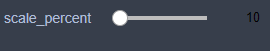
The closer it is to 100%, the longer it takes to load and the laggy it becomes when viewing it.
<br><br>
- To adjust size of each dot:


In [23]:
%matplotlib notebook 
@interact (scale_percent = (10, 100, 10), dot_size = (10, 100, 10))
def show_3dHSV(scale_percent = 10, dot_size = 10):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    temp_image = cv2.resize(image, None, fx=scale_percent/100, fy=scale_percent/100, interpolation = cv2.INTER_AREA) 
    hsv_img = cv2.resize(hsv_img, None, fx=scale_percent/100, fy=scale_percent/100, interpolation = cv2.INTER_AREA) 
    
    h, s, v = cv2.split(hsv_img)
    
    pixel_colors = temp_image.reshape((np.shape(temp_image)[0]*np.shape(temp_image)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()
    
    fig = plt.figure(figsize=(10, 10))
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.scatter(h.flatten(), s.flatten(), v.flatten(), s= dot_size, facecolors = pixel_colors, marker=".")
    axis.set_xlabel("Hue")
    axis.set_ylabel("Saturation")
    axis.set_zlabel("Value")
    plt.show()

interactive(children=(IntSlider(value=10, description='scale_percent', min=10, step=10), IntSlider(value=10, d…

#### 7. Image Segmentation by RGB value to the original image
Filters out pixels of colours with RGB values specified. <br> 
- To select different folder or image, go back to section 1 and section 2. <br><br>
- Adjusting RGB values to filter:
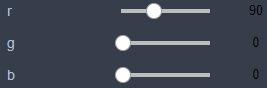
example: above will filter out all pixels with their Red value that is higher or equal to 90.<br>

- To save the filtered image type in your directory:
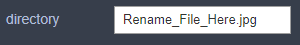
To simply save as a file, e.g. **painting_01.jpg** <br>
To save file in a folder, e.g. **folder01/painting_01.jpg** <br>
- Then press the button at the bottom to save file to the inserted diretory.
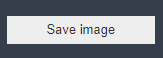

In [41]:
%matplotlib inline
@interact (r = (0, 255, 1), g = (0, 255,1), b = (0, 255,1))
def filterRGB_img(r=0, g=0, b = 0,
                 directory = widgets.Text(value='Rename_File_Here.jpg', disabled=False)):
    
    img_filtered = (image[:,:,0] >= r) & (image[:,:,1] >= g) & (image[:,:,2] >= b)
    plt.figure(num=None, figsize=(15, 15))
    img_new = image.copy()
    img_new[:, :, 0] = img_new[:, :, 0] * img_filtered
    img_new[:, :, 1] = img_new[:, :, 1] * img_filtered
    img_new[:, :, 2] = img_new[:, :, 2] * img_filtered
    plt.imshow(img_new);
    plt.show()
    
    def clicked(arg):
        download_img = Image.fromarray(img_new, 'RGB')
        if len(directory.split('/')) > 1:
            split = directory.split('/')
            folders = directory.replace(split[-1], '')
            Path(folders).mkdir(parents=True, exist_ok=True)
        download_img.save(directory)
        print("saved", end='\r')
    
    save_button = widgets.Button(description = 'Save image')   
    save_button.on_click(clicked)
    display(save_button)

interactive(children=(IntSlider(value=0, description='r', max=255), IntSlider(value=0, description='g', max=25…

#### 8. Image Segmentation by colour palettes value to the re-coloured image
Filters out pixels of colours with a range of colour palettes specified. <br> 
- To select different folder or image, go back to section 1 and section 2. <br><br>
- Adjusting colour palettes to filter:

example: above will filter out all pixels of colours that does not match the top 5 color palettes base on their relative frequency.<br><br>
- 0 having highest relative frequency.To check frequencies you can refer back to the Pie chart at section 4. <br><br>

- then press button to run:
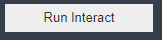
<br>
- To save the filtered image type in your directory:
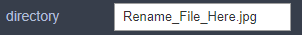
To simply save as a file, e.g. **painting_01.jpg** <br>
To save file in a folder, e.g. **folder01/painting_01.jpg** <br><br>
- Then press the button at the bottom to save file to the inserted diretory.
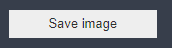

In [46]:
%matplotlib inline
@interact
def filterRGB_by_colour_palettes(colors = widgets.IntRangeSlider(description='colour pattle',
                                value=[0, 26], min = 0, max = len(colour_palette) - 1, step=1),
                 directory = widgets.Text(value='Rename_File_Here.jpg', disabled=False)):
    pil_image = Image.fromarray(recoloured_image)
    cv_image = np.array(pil_image) 

    cv_image = cv_image[:, :, ::-1].copy() 
    cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    plt.figure(num=None, figsize=(15, 15))
    masks = cv2.inRange(cv_image, 0, 1)
    for n in range(colors[0], colors[1], 1):
        rgb = colour_palette[n]

        upper = np.array([rgb[0] + 1, rgb[1] + 1, rgb[2] +1])
        lower = np.array([rgb[0] - 1, rgb[1] - 1, rgb[2] -1])
        mask1 = cv2.inRange(cv_image, lower, upper)
        masks += mask1
    
    
    result = cv2.bitwise_and(cv_image, cv_image, mask = masks)
    
#     fig, ax = plt.subplots(1, 3, figsize=(20,20), sharey = True)

#     ax[0].imshow(image, cmap = 'hsv')
#     ax[0].set_title("original", fontsize = 20)
#     ax[0].axis('off')

#     ax[1].imshow(cv_image, cmap = 'Greys')
#     ax[1].set_title("recoloured", fontsize = 20)
#     ax[1].axis('off')

#     ax[2].imshow(result, cmap = 'gray')
#     ax[2].set_title("masked", fontsize = 20)
#     ax[2].axis('off')
    plt.imshow(result);
    plt.show()
    
    def clicked(arg):
        download_img = Image.fromarray(result, 'RGB')
        if len(directory.split('/')) > 1:
            split = directory.split('/')
            folders = directory.replace(split[-1], '')
            Path(folders).mkdir(parents=True, exist_ok=True)
        download_img.save(directory)
        print("saved", end='\r')
    
    save_button = widgets.Button(description = 'Save image')   
    save_button.on_click(clicked)
    display(save_button)

interactive(children=(IntRangeSlider(value=(0, 24), description='colour pattle', max=24), Text(value='Rename_F…

#### 9. View original image in HSV
Displays image(s) of the original image in their respecting Hue, Saturation, Value. <br> 
- To select different folder or image, go back to section 1 and section 2. <br><br>

- Adjusting viewing options:
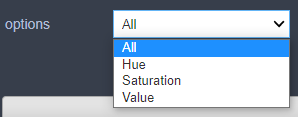
All: view all three side by side.<br>
OR view each seperately.

In [47]:
%matplotlib inline
@interact
def img_HSV(options = ["All", 'Hue','Saturation','Value']):
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    if options == "All":
        hsv_list = ['Hue','Saturation','Value']
        fig, ax = plt.subplots(1, 3, figsize=(10,5), sharey = True)

        ax[0].imshow(img_hsv[:,:,0], cmap = 'hsv')
        ax[0].set_title(hsv_list[0], fontsize = 20)
        ax[0].axis('off')

        ax[1].imshow(img_hsv[:,:,1], cmap = 'Greys')
        ax[1].set_title(hsv_list[1], fontsize = 20)
        ax[1].axis('off')

        ax[2].imshow(img_hsv[:,:,2], cmap = 'gray')
        ax[2].set_title(hsv_list[2], fontsize = 20)
        ax[2].axis('off')
        
        fig.tight_layout()
        
    elif options == "Hue":
        plt.figure(num=None, figsize=(8, 6))
        plt.imshow(img_hsv[:,:,0], cmap='hsv')
        plt.colorbar()
    
    elif options == "Saturation":
        plt.figure(num=None, figsize=(8, 6))
        plt.imshow(img_hsv[:,:,1], cmap='Greys')
        plt.colorbar()
    
    elif options == "Value":
        plt.figure(num=None, figsize=(8, 6))
        plt.imshow(img_hsv[:,:,2], cmap='gray')
        plt.colorbar()
    
    plt.show()

interactive(children=(Dropdown(description='options', options=('All', 'Hue', 'Saturation', 'Value'), value='Al…

#### 10. Image Segmentation by HSV  to the original image
Filters out pixels of colours with Hue and Saturation values specified. <br> 
- To select different folder or image, go back to section 1 and section 2. <br><br>
- Adjusting a range of Hue to filter:

example 1: above will filter out all pixels with their Hue value that is 0 to 60.<br>
<br>
- Adjusting a saturation to filter:

example 2: above will filter out all pixels with their saturation value that is higher or equal to 70.<br>
<br>
- To save the filtered image type in your directory:
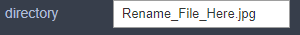
To simply save as a file, e.g. **painting_01.jpg** <br>
To save file in a folder, e.g. **folder01/painting_01.jpg** <br>
<br>
- Then press the button at the bottom to save file to the inserted diretory.
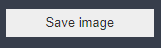

In [49]:
%matplotlib inline
@interact (Saturation = (0, 255, 1))
def img_HSV_filter(h = widgets.IntRangeSlider(description='Hue', value=[0, 255],
                                               min = 0, max = 255, step=1),
                    Saturation = 0,
                  directory = widgets.Text(value='Rename_File_Here.jpg', disabled=False)):
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_mask = img_hsv[:,:,0] >= int(h[0])
    upper_mask = img_hsv[:,:,0] <= int(h[1])
    saturation = img_hsv[:,:,1] >= Saturation
    mask = upper_mask * lower_mask * saturation
    red = image[:,:,0] * mask
    green = image[:,:,1] * mask
    blue = image[:,:,2] * mask
    image_masked = np.dstack((red,green,blue))
    plt.figure(num=None, figsize=(15, 15))
    plt.imshow(image_masked);
    
    plt.show()
    
    def clicked(arg):
        download_img = Image.fromarray(image_masked, 'RGB')
        if len(directory.split('/')) > 1:
            split = directory.split('/')
            folders = directory.replace(split[-1], '')
            Path(folders).mkdir(parents=True, exist_ok=True)
        download_img.save(directory)
        print("saved", end='\r')
    
    save_button = widgets.Button(description = 'Save image')   
    save_button.on_click(clicked)
    display(save_button)

interactive(children=(IntRangeSlider(value=(0, 255), description='Hue', max=255), IntSlider(value=0, descripti…

In [50]:
# convert image into pandas.dataframe
def image_to_df(img):
    df = pd.DataFrame([img[:,:,0].flatten(), img[:,:,1].flatten(), img[:,:,2].flatten()]).T
    df.columns = ['R','G','B']
    return df

#### 11. Image Segmentation by HSV to the original image using K-means Clustering
Filters out pixels of colours with Hue and Saturation values by specifying number of clusters for K- means clustering algorithm. <br> 
- To select different folder or image, go back to section 1 and section 2. <br><br>
- Adjusting a number of 'K':

example 1: above will set 'K' to 9.<br>
<br>
- Then press button to run:
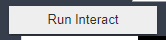
<br>
- To save the filtered image type in your directory:
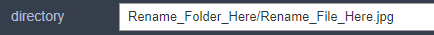
To simply save as a file, e.g. **painting_01.jpg** <br>
To save file in a folder, e.g. **folder01/painting_01.jpg** <br>
<br>
- Then press the button at the bottom to save file to the inserted diretory.
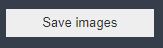

In [55]:
%matplotlib inline
@interact_manual (k = (2, 50, 1))
def img_HSV_filter(k = 2, 
                   directory = widgets.Text(value='Rename_Folder_Here/Rename_File_Here.jpg', 
                                            disabled=False,
                                           layout=widgets.Layout(height="auto", width="auto"))):
    temp_df = image_to_df(image)
    
    plt.figure(num=None, figsize=(10, 10))
    plt.imshow(image);
    
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(temp_df)
    result = kmeans.labels_.reshape(image.shape[0],image.shape[1])
    
    fig, ax = plt.subplots(math.ceil(k/2), 2, figsize=(15, 5 * math.ceil(k/2)), sharey = True)

    temp_save_as = []
    
    for n in range(k):
        temp_img = image.copy()
        temp_img[:, :, 0] = temp_img[:, :, 0]*(result==[n])
        temp_img[:, :, 1] = temp_img[:, :, 1]*(result==[n])
        temp_img[:, :, 2] = temp_img[:, :, 2]*(result==[n])
        temp_save_as.append(temp_img)
        if k == 2:
            ax[n].imshow(temp_img)
            ax[n].axis('off')
        else:
            ax[math.floor(n/2), n%2].imshow(temp_img)
            ax[math.floor(n/2), n%2].axis('off')

#         plt.figure(num=None, figsize=(5, 5))
#         plt.imshow(temp_img);
    
    plt.show()
    
    def clicked(arg):
        if len(directory.split('/')) > 1:
            split = directory.split('/')
            folders = directory.replace(split[-1], '')
            Path(folders).mkdir(parents=True, exist_ok=True)
        
        for n in range(len(temp_save_as)):
            download_img = Image.fromarray(temp_save_as[n], 'RGB')
            download_img.save(directory.split('.')[0] + "_" + str(n) + ".jpg")
            
        print("saved", end='\r')
    
    save_button = widgets.Button(description = 'Save images')   
    save_button.on_click(clicked)
    display(save_button)

interactive(children=(IntSlider(value=2, description='k', max=50, min=2), Text(value='Rename_Folder_Here/Renam…